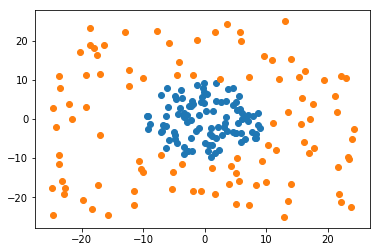

In [183]:
%matplotlib inline
import numpy as np
import os, string
from matplotlib import pyplot as plt
import tensorflow as tf

center=np.mat([0.,0.])
#center2=np.mat([10.,10.])
#generate data
radius = 10.
num1=100
num2 = 100
np.random.seed(0)
data1 = np.ones([num1,3])
data2 = np.ones([num2,3])*-1.0
for i in range(0,num1):
    data1[i,:2] = 50. * (np.random.random([1,2])-0.5)
    while(np.linalg.norm(data1[i,:2]-center) > 10.0):
        data1[i,:2] = 50. * (np.random.random([1,2])-0.5)
for i in range(0,num2): 
    while(np.linalg.norm(data2[i,:2]-center) < 10.0):
        #print(data2[i,:])
        data2[i,:2] = 50. * (np.random.random([1,2])-0.5)
        
plt.scatter(x=data1[:,0],y=data1[:,1])
plt.scatter(x=data2[:,0],y=data2[:,1])
plt.show()

In [184]:
sigma = 0.1
x=np.mat(np.vstack((data1,data2)))
#print(np.tile(x[:,0].T,[x.shape[0],1]))
#print(np.tile(x[:,0],[1,x.shape[0]]))
kkx = np.square(np.tile(x[:,0].T,[x.shape[0],1])-np.tile(x[:,0],[1,x.shape[0]]))
#print(kkx)
kkx += np.square(np.tile(x[:,1].T,[x.shape[0],1])-np.tile(x[:,1],[1,x.shape[0]]))
kkx = np.sqrt(kkx)
kkx = np.exp(-sigma * kkx )
print(kkx)
print(kkx.shape)

[[ 1.          0.35767067  0.46460669 ...,  0.09105158  0.11604101
   0.23749968]
 [ 0.35767067  1.          0.28476585 ...,  0.20938626  0.12194354
   0.1228445 ]
 [ 0.46460669  0.28476585  1.         ...,  0.06005833  0.24094547
   0.43129903]
 ..., 
 [ 0.09105158  0.20938626  0.06005833 ...,  1.          0.02957171
   0.02592518]
 [ 0.11604101  0.12194354  0.24094547 ...,  0.02957171  1.          0.23361438]
 [ 0.23749968  0.1228445   0.43129903 ...,  0.02592518  0.23361438  1.        ]]
(200, 200)


In [265]:
lam = 1./2.
batch = x.shape[0]
with tf.device('/cpu:0'):
    alpha = tf.Variable(tf.random_uniform([batch,1],-1.0,1.0))
    KX = tf.placeholder("float", shape=[batch,batch])
    y = tf.placeholder("float", shape=[batch,1])
    loss = lam*tf.reduce_sum(tf.matmul(alpha,tf.transpose(alpha))*KX)
    tmp = tf.matmul(KX, alpha)
    tmp = y*tmp
    tmp = 1. - tmp
    tmp = tf.maximum(0.,tmp)
    tmp = 1./batch*tf.reduce_sum(tmp)
    loss += tmp
    optimizer = tf.train.GradientDescentOptimizer(0.00002)
    train_op = optimizer.minimize(loss)
    predict_op = tf.reduce_sum(tf.reduce_sum(alpha*KX,1) - y)

In [267]:
import sys,time
# test1 = tf.Variable([[1,2,3,4]])
# test2 = tf.tile(test1,[4,1])
# test3 = tf.tile(tf.reshape(test1,[4,1]),[1,4])
# test4=test2*test3-5
# test5=tf.maximum(0,test4)
# sess = tf.Session()
# init = tf.global_variables_initializer()
# sess.run(init)
# print(sess.run(test2))
# print(sess.run(test3))
# print(sess.run(test4))
# print(sess.run(test5))
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for i in range(8000):
    #sys.stdout.write('\r epoch : %d' % i)
    #sys.stdout.flush()
    #time.sleep(0.2)
    _,pre = sess.run([train_op,predict_op], feed_dict={KX: kkx, y: x[:,2]})
    if i % 500 == 0:
        print(i,'loss:',pre)
    
resA = sess.run(alpha)
#print(resA)
#w=kkx

0 loss: 1176.1
500 loss: 2764.02
1000 loss: 3524.2
1500 loss: 3837.53
2000 loss: 3973.1
2500 loss: 4082.55
3000 loss: 4160.74
3500 loss: 4226.51
4000 loss: 4326.84
4500 loss: 4390.17
5000 loss: 4410.02
5500 loss: 4380.2
6000 loss: 4325.04
6500 loss: 4252.4
7000 loss: 4178.7
7500 loss: 4105.6


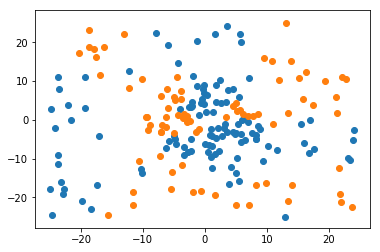

In [268]:
#print(resA.shape,kkx.shape)
predict=np.sum(resA.T*kkx,axis=0)
predict = predict.T
#print(predict.shape)
#duibi = np.zeros((100,2))
#print(duibi.shape)
#duibi[:,0] = np.mat(predict.T>0.0).T
#duibi[:,1] = x[:,2].T>0
#print(duibi)
#print(predict>0.0)
#print(predict.shape)
predict=np.tile(predict,[1,3])
#print(predict>0.0)
ax = np.array(x)
predictSet1=ax[predict>0.0].reshape([-1,3])
predictSet2=ax[predict<0.0].reshape([-1,3])

#print(predictSet1)
plt.scatter(x=predictSet1[:,0],y=predictSet1[:,1])
plt.scatter(x=predictSet2[:,0],y=predictSet2[:,1])
plt.show()
#print(x)